In [31]:
import xarray as xr

In [13]:


ds = xr.open_dataset('/Users/bhupendra/projects/crocus/data/flux_data/data/netcdf/smartflux_rawdata_2024_07.nc')


def calculate_wind_components(ds):
    """Calculates wind speed and direction from dataset."""
    U = ds['U_m_s'].values
    V = ds['V_m_s'].values
    W = ds['W_m_s'].values

    wind_speed = np.sqrt(U**2 + V**2)
    wind_direction = np.rad2deg(np.arctan2(V, U)) % 360
    return wind_speed, wind_direction, W

wind_speed, wind_direction, W = calculate_wind_components(ds)

ds['Wind_Speed'] = ("time", wind_speed)
ds['Wind_Direction'] = ("time", wind_direction)
ds['W_Normalized'] = ("time", W / wind_speed)

(array([1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        2.0000000e+00, 0.0000000e+00, 5.0000000e+00, 1.0000000e+00,
        3.0000000e+00, 7.0000000e+00, 1.0000000e

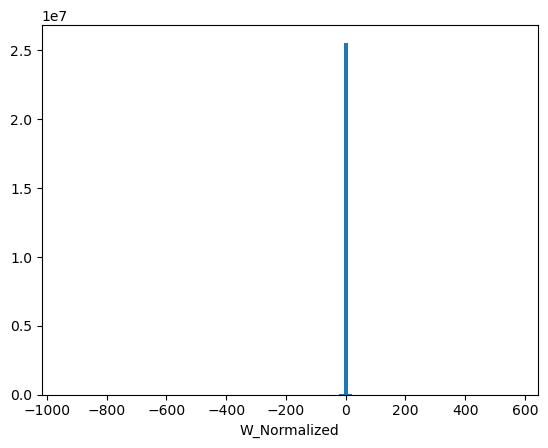

In [4]:
ds.W_Normalized.plot.hist(bins=105)


In [10]:
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

def compute_hourly_means(ds, output_file='hourly_means.nc'):
    """Computes hourly means from 10 Hz data and saves the results."""
    # Convert time to a Pandas datetime format
    ds['time'] = pd.to_datetime(ds['time'].values, unit='s')

    # Resample to hourly data by taking the mean
    ds_hourly = ds.resample(time='1H').mean()

    # Calculate wind components for hourly data
    wind_speed, wind_direction, W = calculate_wind_components(ds_hourly)
    ds_hourly['Wind_Speed'] = ('time', wind_speed)
    ds_hourly['Wind_Direction'] = ('time', wind_direction)
    ds_hourly['W_Normalized'] = ('time', W / wind_speed)

    # Group by hour of the day to get diurnal means
    ds_diurnal = ds_hourly.groupby('time.hour').mean()

    # Save to a NetCDF file
    ds_diurnal.to_netcdf(output_file)

def plot_normalized_w_vs_direction(ds):
    """Plots W normalized by wind speed vs wind direction."""
    plt.figure(figsize=(14, 6))
    sns.scatterplot(x=ds.Wind_Direction, y=ds.W_Normalized, alpha=0.7)
    plt.title('Normalized Vertical Wind Speed (W) vs. Wind Direction')
    plt.xlabel('Wind Direction (degrees)')
    plt.ylabel('W Normalized by Wind Speed')
    plt.grid(True)
    plt.show()

def plot_normalized_w_vs_direction_hexbin(ds):
    """Plots W normalized by wind speed vs wind direction using hexbin."""
    plt.figure(figsize=(14, 6))
    plt.hexbin(ds.Wind_Direction, ds.W_Normalized, gridsize=50, cmap='viridis', mincnt=1)
    plt.colorbar(label='Counts')
    plt.title('Normalized Vertical Wind Speed (W) vs. Wind Direction')
    plt.xlabel('Wind Direction (degrees)')
    plt.ylabel('W Normalized by Wind Speed')
    plt.grid(True)
    plt.show()


 
def plot_diurnal_variation(ds):
    """Plots diurnal variations of wind speed, direction, normalized W, and temperature."""
    # Convert time to a Pandas datetime format (assuming hourly data)
    ds['time'] = pd.to_datetime(ds['time'], unit='h')

    # Group by hour 
    ds_grouped = ds.groupby(ds['time.hour']).mean()

    # Plot the diurnal variations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    variable_names = ['Wind_Speed', 'Wind_Direction', 'W_Normalized', 'T_C']
    titles = ['Wind Speed', 'Wind Direction', 'Normalized W', 'Temperature']
    y_labels = ['Speed (m/s)', 'Direction (degrees)', 'Normalized W', 'Temperature (C)']

    for i, var in enumerate(variable_names):
        sns.lineplot(x=ds_grouped['time.hour'], y=ds_grouped[var], ax=axes[i])
        axes[i].set_title(f'Diurnal Variation of {titles[i]}')
        axes[i].set_xlabel('Hour of Day')
        axes[i].set_ylabel(y_labels[i])

    plt.tight_layout()
    plt.show()


def plot_histograms(ds):
    """Plots histograms for U, V, W, T, wind speed, and wind direction variables."""
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    axes = axes.flatten()

    variable_names = ['U_m_s', 'V_m_s', 'W_m_s', 'T_C', 'Wind_Speed', 'Wind_Direction']
    titles = ['U', 'V', 'W', 'Temperature', 'Wind Speed', 'Wind Direction']

    for i, var in enumerate(variable_names):
        sns.histplot(ds[var].values, bins=30, ax=axes[i], kde=True)
        axes[i].set_title(f'{titles[i]} Histogram')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()



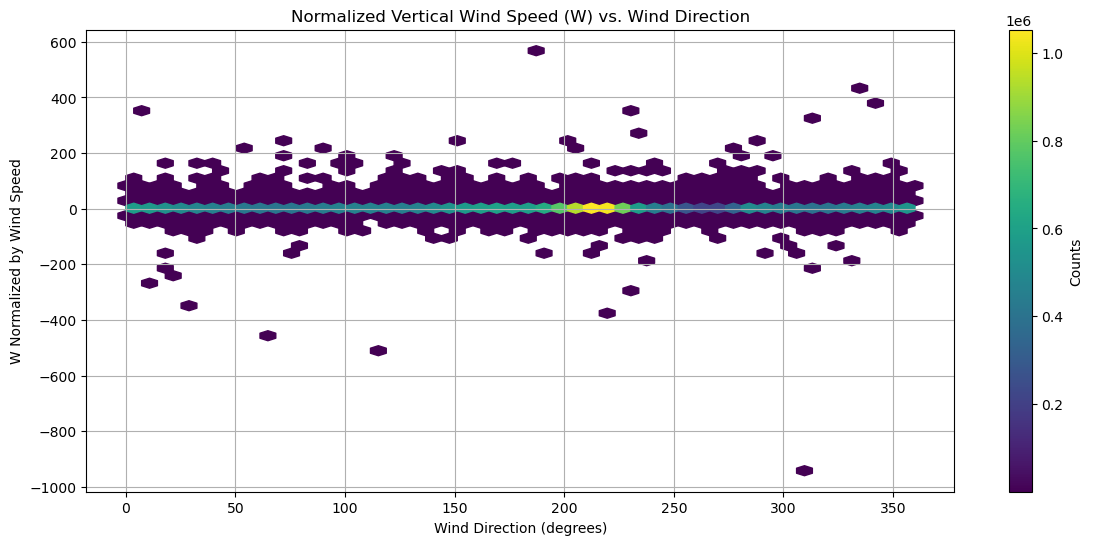

In [14]:


plot_normalized_w_vs_direction_hexbin(ds)


In [ ]:

# Plot normalized W vs wind direction
plot_normalized_w_vs_direction(wind_direction, W_normalized)


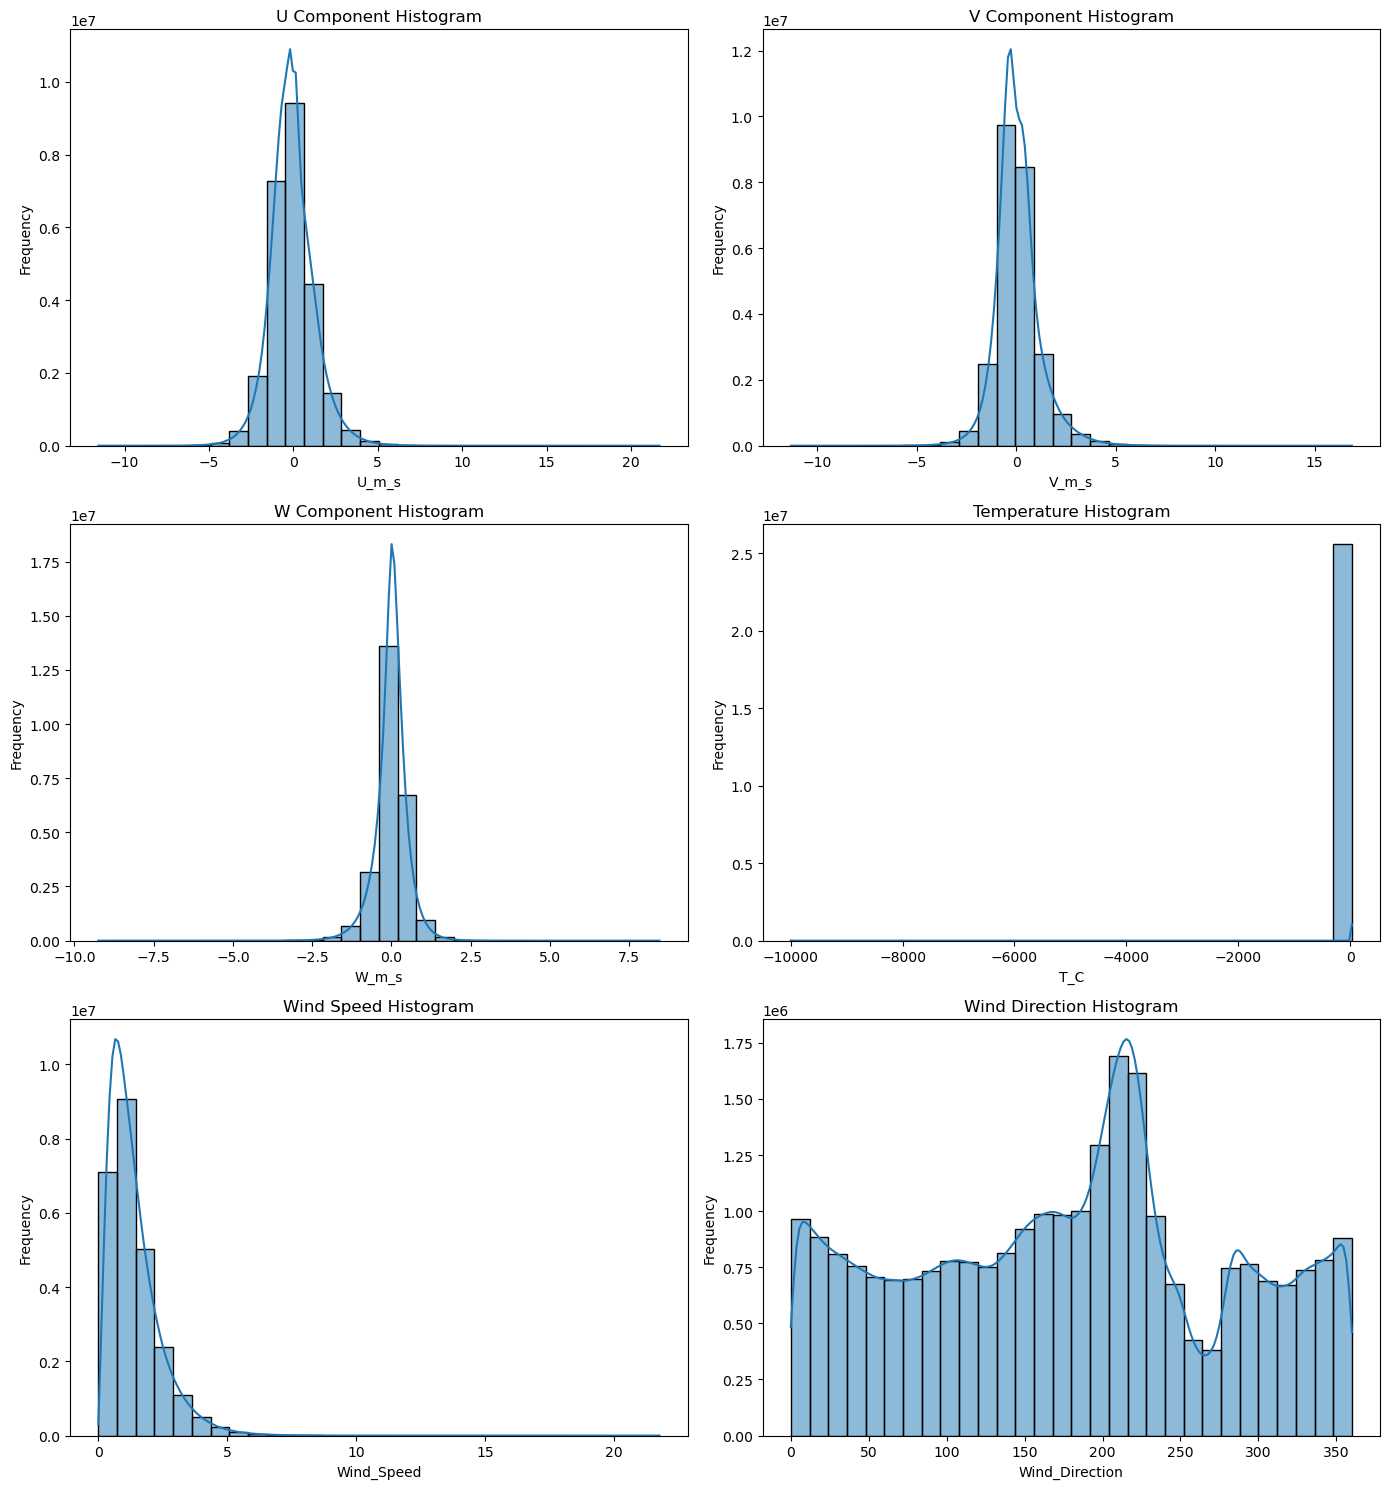

In [52]:

# Plot histograms of the 6 variables
plot_histograms(ds)




In [55]:
plot_diurnal_variation(ds)